In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from scipy.integrate import simps
from pymodelfit import FunctionModel1DAuto
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import warnings
import glob
warnings.filterwarnings('ignore')

In [3]:
dmo = wkbl.astro.halo_info.HALOCdmo()
hydro = wkbl.astro.halo_info.HALOCHydro()

In [4]:

simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
print myhydro.dm.pos3d[:,0].max()
#zoom_reg = np.where(myhydro.dm.mass==myhydro.dm.mass.min())
#nucenter = nbe.real_center(myhydro.dm.pos3d[zoom_reg], myhydro.dm.mass[zoom_reg])
myhydro.center_shift(hydro.c_dm_com)
myhydro.r_virial(600,n=2.3)



loading Dark matter..
loading Stars..
loading Gas..
19879.998
| r_200 = 182.23
| Diagonal matrix computed 
|    | 18, 0, 0|
| D =| 0, 13, 0|
|    | 0,  0, 3|


In [5]:
simname_nospace = list(simname)
for i in range(len(simname)):
    if simname[i]==" ":
        simname_nospace[i]="_"
simname_nospace = "".join(simname_nospace)


In [6]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

45407310 45407310


# Ellipticity T and S

In [7]:
get_mat =  np.vectorize(nbe.m_matrix_for_r)

In [8]:
r = np.linspace(myhydro.gs.hsml.min(),2*myhydro.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myhydro,'halo',i) for i in r])
M_st = np.array([nbe.m_matrix_for_r(myhydro,'stars',i) for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
a_st, b_st, c_st = np.sqrt(M_st[:,0,0]), np.sqrt(M_st[:,1,1]), np.sqrt(M_st[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 
S_st = c_st/a_st
T_st = ((a_st**2) - (b_st**2))/((a_st**2) -(c_st**2)) 

In [9]:
outputing = open("../../datafiles/"+simname_nospace+"_S_and_T.txt","w")
outputing.write("# "+simname+" ellipticity parameters\n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# r (kpc), S , T\n")
for i in range(len(T_dm)):
    outputing.write("{0:.2f} {1:.6f} {2:.6f} \n".format(r[i],S_dm[i],T_dm[i]))

outputing.close()

<IPython.core.display.Javascript object>


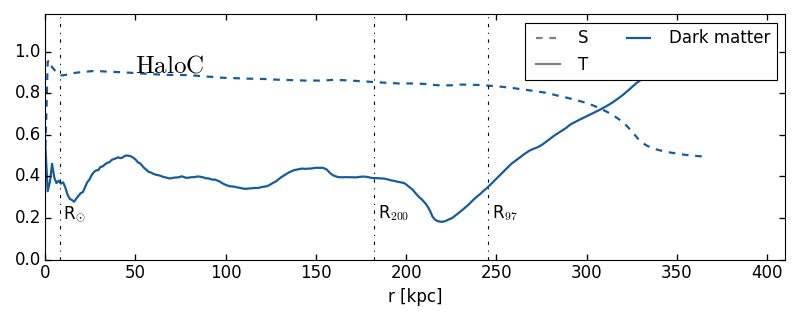

In [10]:
fig, ax = plt.subplots(figsize=[10,4])
#ax.set_xlim(4,250)
font=15
ax.set_ylim(0,1.18)
ax.set_xlim(0,410)
ax.set_xlabel('r [kpc]',fontsize=font)
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='--',lw=2,label="S")
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='-',lw=2,label="T")
ax.plot(r,T_dm,'-',color='#155c9e',lw=2,label="Dark matter")
ax.plot(r,S_dm,'--',color='#155c9e',lw=2)
#ax.plot(r,T_st,'-',color='#a91e4f',lw=2,label='stars')
#ax.plot(r,np.sqrt(S_st),'--',color='#a91e4f',lw=2)
ax.axvline(x=myhydro.r200,color='k',linestyle='-.')
ax.text(myhydro.r200+2,0.2,r"R$_{200}$",fontsize=font)
ax.axvline(x=myhydro.r97,color='k',linestyle='-.')
ax.text(myhydro.r97+2,0.2,r"R$_{97}$",fontsize=font)
ax.axvline(x=8,color='k',linestyle='-.')
ax.text(10,0.2,r"R$_{\odot}$",fontsize=font)
ax.text(50,0.9,r"$\rm "+simname+"$",fontsize=1.5*font)



legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

# Beta of r

In [11]:
point_num = 150
r_beta = np.logspace(-1,np.log10(4*myhydro.r200),point_num)
vphi = np.concatenate((myhydro.dm.vphi,myhydro.st.vphi,myhydro.gs.vphi))
vtheta = np.concatenate((myhydro.dm.vtheta,myhydro.st.vtheta,myhydro.gs.vtheta))
vr = np.concatenate((myhydro.dm.vr,myhydro.st.vr,myhydro.gs.vr))

In [12]:
def beta_param(i):
    condition = np.where((r2>r_beta[i]**2)&(r2<=r_beta[i+1]**2))
    v_r = vr[condition]
    v_phi = vphi[condition]
    v_theta = vtheta[condition]
    #print (np.std(v_phi))**2 ,(np.std(v_theta))**2 , (np.std(v_r))**2  
    return 1 - ((np.std(v_phi))**2 +(np.std(v_theta))**2) / 2. / (np.std(v_r))**2  

get_beta = np.vectorize(beta_param)

In [13]:
beta_r = get_beta(range(point_num-1))

In [14]:
outputing = open("../../datafiles/"+simname_nospace+"_Beta.txt","w")
outputing.write("# "+simname+" Beta parameters\n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# r (kpc), Beta(r) \n")
for i in range(len(beta_r)):
    outputing.write("{0:.2f} {1:.6f} \n".format(((r_beta[1:]+r_beta[:-1])/2.)[i],beta_r[i]))

outputing.close()

<IPython.core.display.Javascript object>


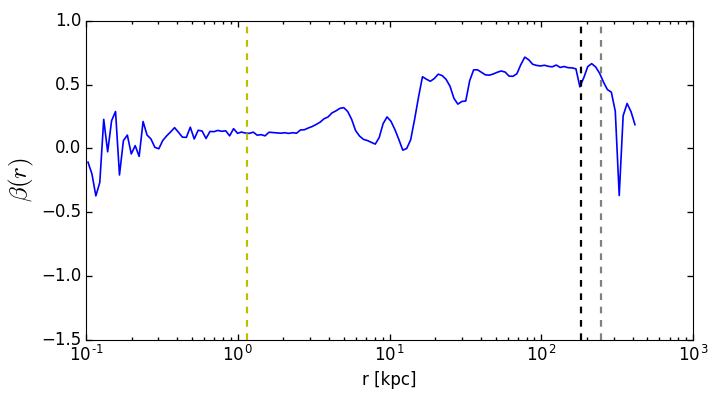

In [15]:
fig, ax = plt.subplots(figsize=[9,5])
r_2 = 6.95
ax.set_xscale('log')
#ax.set_title(r"$\beta(r)$ parameter", fontsize=1.5*font)
ax.set_xlabel(r"r [kpc]",fontsize=font)
ax.set_ylabel(r"$\beta(r)$",fontsize=1.5*font)
ax.set_ylim([-1.5,1])
ax.plot((r_beta[1:]+r_beta[:-1])/2.,beta_r,lw=1.5)
#ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_2,lw=1.5)
#ax.plot((r_beta[1:]+r_beta[:-1])/2/r_2,beta_r_3,lw=1.5)


ax.axvline(x=myhydro.r200, color='k',lw=2,linestyle='--')
ax.axvline(x=myhydro.r97, color='gray',lw=2,linestyle='--')

ax.axvline(x=8/r_2, color='y',linestyle='--',lw=2,label=r'r$_{\odot}$')
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/beta_r.png",dpi=300)

# F(v) moments

In [16]:
def moments(rmin,rmax):
    selection= np.where((myhydro.dm.r>rmin)&(myhydro.dm.r<=rmax))
    fdv, vs = np.histogram(myhydro.dm.v[selection],bins=50,normed=1)
    vcenter = (vs[:-1]+vs[1:])/2.
    m1 = simps(vcenter*fdv,x=vcenter)
    m2 = simps((vcenter**2)*fdv,x=vcenter)
    m3 = simps((vcenter**3)*fdv,x=vcenter)

    return m1,m2,m3

def moments2(rmin,rmax):
    selection= np.where((myhydro.dm.r>rmin)&(myhydro.dm.r<=rmax))
    fdv, vs = np.histogram(myhydro.dm.v[selection],bins=50,normed=1)
    vcenter = (vs[:-1]+vs[1:])/2.
    vw = vs[1:]-vs[:-1]
    m1 = np.sum(vcenter*fdv*vw)
    m2 = np.sum((vcenter**2)*fdv*vw)
    m3 = np.sum((vcenter**3)*fdv*vw)

    return m1,m2,m3

def moments3(sim,rmin,rmax):
    selection= np.where((sim.dm.r>rmin)&(sim.dm.r<=rmax))
    npart = len(sim.dm.v[selection])
    m_2 = np.sum(sim.dm.v[selection]**(-2))/npart
    m_1 = np.sum(sim.dm.v[selection]**(-1))/npart
    m1 = np.sum(sim.dm.v[selection])/npart
    m2 = np.sum((sim.dm.v[selection])**2)/npart
    std_2 = np.std(sim.dm.v[selection]**(-2))
    std_1 = np.std(sim.dm.v[selection]**(-1))
    std1 = np.std(sim.dm.v[selection])
    std2 = np.std((sim.dm.v[selection])**2)
    return m_2,m_1,m1, m2, npart, std_2, std_1, std1, std2

fdv_moments = np.vectorize(moments)
fdv_moments2 = np.vectorize(moments2)
fdv_moments3 = np.vectorize(moments3)




In [32]:
patho = "/home/arturo/Documents/LAM/LAM2LUPM/speed/"+hydro.namenospace
cd = "/home/arturo/Documents/LAM/LAM2LUPM/speed/Adicora/Eddington/v_minus1_av_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_no_divergence.txt"
v_2_av = np.loadtxt(glob.glob(patho+"/Eddington/v_minus2_av_Eddington_"+hydro.namenospace+"_DM_bary*")[0])
v_1_av = np.loadtxt(glob.glob(patho+"/Eddington/v_minus1_av_Eddington_"+hydro.namenospace+"_DM_bary*")[0])
v_av = np.loadtxt(glob.glob(patho+"/Eddington/v_av_Eddington_"+hydro.namenospace+"_DM_bary*")[0])
v2_av = np.loadtxt(glob.glob(patho+"/Eddington/v_sq_av_Eddington_"+hydro.namenospace+"_DM_bary*")[0])


v_2_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_minus2_av_"+hydro.namenospace+"_DM_bary*")[0])
v_1_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_minus1_av_"+hydro.namenospace+"_DM_bary*")[0])
v_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_av_"+hydro.namenospace+"_DM_bary*")[0])
v2_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_sq_av_"+hydro.namenospace+"_DM_bary*")[0])


In [33]:
r_v = np.logspace(np.log10(4*myhydro.gs.hsml.min()),np.log10(3*myhydro.r200),150)
#m1,m2,m3 = fdv_moments(r_v[:-1],r_v[1:])
#mm1,mm2,mm3 = fdv_moments2(r_v[:-1],r_v[1:])
m_2, m_1,m1, m2, n, std_2, std_1, std1, std2 = fdv_moments3(myhydro,r_v[:-1],r_v[1:])

<IPython.core.display.Javascript object>


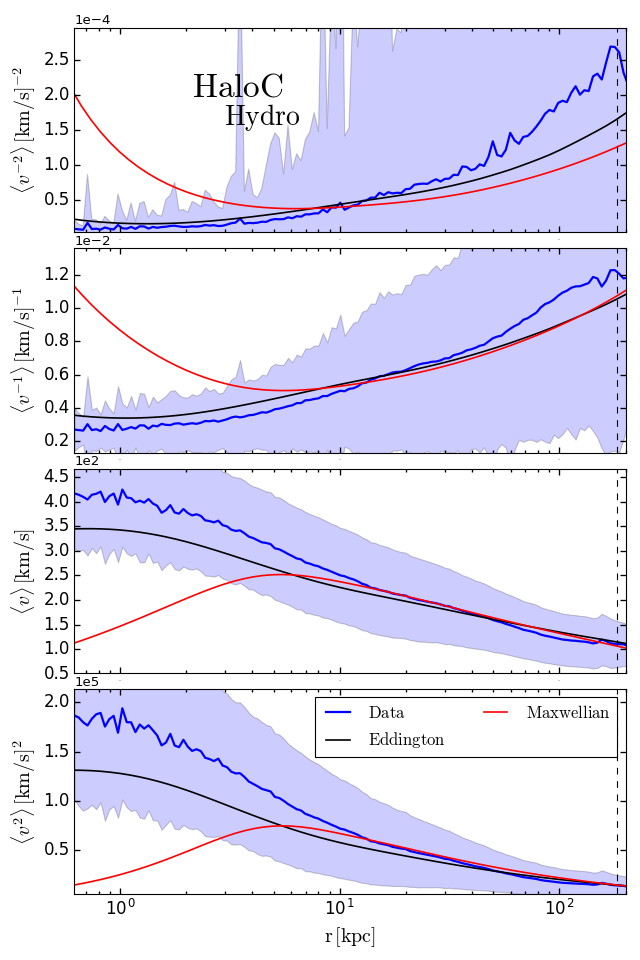

In [34]:

fig, ax = plt.subplots(4,1,figsize=[8,12])
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[2].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[3].yaxis.get_major_formatter().set_powerlimits((0, 2))


ax[3].set_xlabel(r'$\rm r\,[kpc]$',fontsize=18)
ax[0].set_ylabel(r'$\langle v^{-2} \rangle$$\rm \, [km/s]^{-2}$',fontsize=18)
ax[1].set_ylabel(r'$\langle v^{-1} \rangle$$\rm \,[km/s]^{-1}$',fontsize=18)
ax[2].set_ylabel(r'$\langle v \rangle$$\rm \,[km/s]$',fontsize=18)
ax[3].set_ylabel(r'$\langle v^{2} \rangle$$\rm \,[km/s]^2$',fontsize=18)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_ylim([0.5*np.nanmin(m_2),1.1*np.nanmax(m_2)])
ax[1].set_ylim([0.5*np.nanmin(m_1),1.1*np.nanmax(m_1)])
ax[2].set_ylim([0.5*np.nanmin(m1),1.1*np.nanmax(m1)])
ax[3].set_ylim([0.5*np.nanmin(m2),1.1*np.nanmax(m2)])

#ax[1].set_ylim([m_1.min(),1.1*m_1.max()])
#ax[2].set_ylim([m1.min(),1.1*m1.max()])
#ax[3].set_ylim([m2.min(),1.1*m2.max()])
r_v_c = (r_v[:-1]+r_v[1:])/2.
ax[0].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[1].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[2].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[3].set_xlim([r_v_c.min(),v_av[:,0].max()])

ax[0].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[1].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[2].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[3].axvline(x=myhydro.r200,color='k',linestyle='--')



alpha=0.2

ax[0].plot(r_v_c,m_2,lw=2)
ax[0].fill_between(r_v_c,m_2-std_2,m_2+std_2,alpha=alpha)
ax[0].plot(v_2_av[:,0],v_2_av[:,1],"k",lw=1.5)
ax[0].plot(v_2_av_m[:,0],v_2_av_m[:,1],"r",lw=1.5)
fig.text(0.3,.9,r"$\rm"+ hydro.name +" $",fontsize=30)
fig.text(0.35,.87,r"$\rm Hydro $",fontsize=25)


ax[1].plot(r_v_c,m_1,lw=2,label=r"$\rm Data$")
ax[1].fill_between(r_v_c,m_1-std_1,m_1+std_1,alpha=alpha)

ax[1].plot(v_1_av[:,0],v_1_av[:,1],"k",lw=1.5,label=r"$\rm Eddington$")
ax[1].plot(v_1_av_m[:,0],v_1_av_m[:,1],"r",lw=1.5,label=r"$\rm Maxwellian$")

ax[2].plot(r_v_c,m1,lw=2)
ax[2].fill_between(r_v_c,m1-std1,m1+std1,alpha=alpha)

ax[2].plot(v_av[:,0],v_av[:,1],"k",lw=1.5)
ax[2].plot(v_av_m[:,0],v_av_m[:,1],"r",lw=1.5)

ax[3].plot(r_v_c,m2,lw=2,label=r"$\rm Data$")
ax[3].fill_between(r_v_c,m2-std2,m2+std2,alpha=alpha)


ax[3].plot(v2_av[:,0],v2_av[:,1],"k",lw=1.5,label=r"$\rm Eddington$")
ax[3].plot(v2_av_m[:,0],v2_av_m[:,1],"r",lw=1.5,label=r"$\rm Maxwellian$")
legend = ax[3].legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()

fig.tight_layout(h_pad=-1.5)
ax[2].text(170,1e7,r'R$_{200}$',fontsize=17)


ax[0].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[2].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[2].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[2].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[3].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[3].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/VdfComparison/v_moments_"+hydro.namenospace+"_hydro.pdf",dpi=300)

# DMO

In [20]:

myDMO = wkbl.Galaxy_Hound(dmo.path)
myDMO.center_shift(dmo.c_dm_com)
myDMO.r_virial(600,n=20)

loading Dark matter..


In [21]:
r = np.linspace(4*myhydro.gs.hsml.min(),2*myDMO.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myDMO,'halo',i) for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 


In [22]:
outputing = open("../../datafiles/"+ dmo.namenospace +"_S_and_T_DMO.txt","w")
outputing.write("# "+dmo.name+" ellipticity parameters\n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# r (kpc), S , T\n")
for i in range(len(T_dm)):
    outputing.write("{0:.2f} {1:.6f} {2:.6f} \n".format(r[i],S_dm[i],T_dm[i]))

outputing.close()

<IPython.core.display.Javascript object>


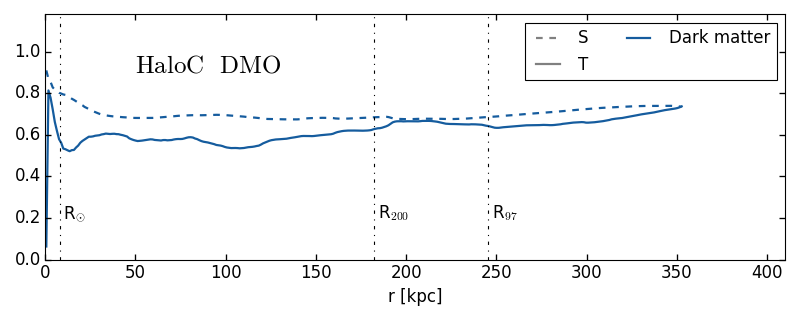

In [23]:
fig, ax = plt.subplots(figsize=[10,4])
#ax.set_xlim(4,250)
font=15
ax.set_ylim(0,1.18)
ax.set_xlim(0,410)
ax.set_xlabel('r [kpc]',fontsize=font)
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='--',lw=2,label="S")
ax.plot([4,5],[1e3,2e3],color='gray',linestyle='-',lw=2,label="T")
ax.plot(r,T_dm,'-',color='#155c9e',lw=2,label="Dark matter")
ax.plot(r,S_dm,'--',color='#155c9e',lw=2)
#ax.plot(r,T_st,'-',color='#a91e4f',lw=2,label='stars')
#ax.plot(r,np.sqrt(S_st),'--',color='#a91e4f',lw=2)
ax.axvline(x=myhydro.r200,color='k',linestyle='-.')
ax.text(myhydro.r200+2,0.2,r"R$_{200}$",fontsize=font)
ax.axvline(x=myhydro.r97,color='k',linestyle='-.')
ax.text(myhydro.r97+2,0.2,r"R$_{97}$",fontsize=font)
ax.axvline(x=8,color='k',linestyle='-.')
ax.text(10,0.2,r"R$_{\odot}$",fontsize=font)
ax.text(50,0.9,r"$\rm "+dmo.name+"$"+r"  $\rm DMO$",fontsize=1.5*font)



legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

# moments

In [24]:
patho = "/home/arturo/Documents/LAM/LAM2LUPM/speed/"+hydro.namenospace
cd = "/home/arturo/Documents/LAM/LAM2LUPM/speed/Adicora/Eddington/v_minus1_av_Eddington_Adicora_DM_"
v_2_av = np.loadtxt(glob.glob(patho+"/Eddington/v_minus2_av_Eddington_"+hydro.namenospace+"_DM_o*")[0])
v_1_av = np.loadtxt(glob.glob(patho+"/Eddington/v_minus1_av_Eddington_"+hydro.namenospace+"_DM_o*")[0])
v_av = np.loadtxt(glob.glob(patho+"/Eddington/v_av_Eddington_"+hydro.namenospace+"_DM_o*")[0])
v2_av = np.loadtxt(glob.glob(patho+"/Eddington/v_sq_av_Eddington_"+hydro.namenospace+"_DM_o*")[0])


v_2_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_minus2_av_"+hydro.namenospace+"_DM_o*")[0])
v_1_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_minus1_av_"+hydro.namenospace+"_DM_o*")[0])
v_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_av_"+hydro.namenospace+"_DM_o*")[0])
v2_av_m = np.loadtxt(glob.glob(patho+"/Maxwellian/v_sq_av_"+hydro.namenospace+"_DM_o*")[0])

In [25]:
r_v = np.logspace(np.log10(4*myhydro.gs.hsml.min()),np.log10(3*myDMO.r200),150)
#m1,m2,m3 = fdv_moments(r_v[:-1],r_v[1:])
#mm1,mm2,mm3 = fdv_moments2(r_v[:-1],r_v[1:])
m_2, m_1,m1, m2, npart, std_2, std_1, std1, std2 = fdv_moments3(myDMO,r_v[:-1],r_v[1:])

<IPython.core.display.Javascript object>


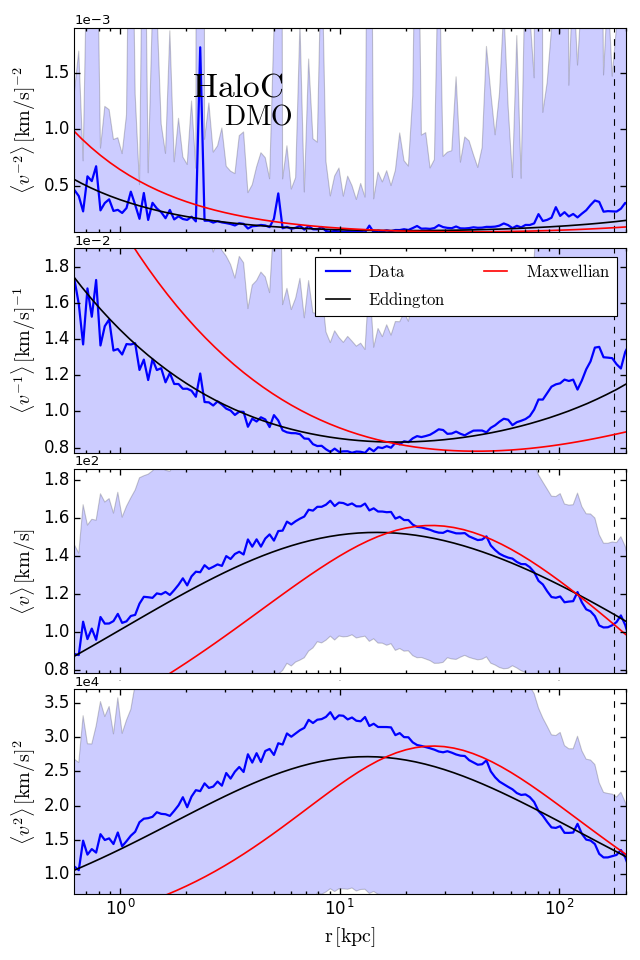

In [26]:

fig, ax = plt.subplots(4,1,figsize=[8,12])
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[2].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[3].yaxis.get_major_formatter().set_powerlimits((0, 2))


ax[3].set_xlabel(r'$\rm r\, [kpc]$',fontsize=18)
ax[0].set_ylabel(r'$\langle v^{-2} \rangle$$\rm \, [km/s]^{-2}$',fontsize=18)
ax[1].set_ylabel(r'$\langle v^{-1} \rangle$$\rm \,[km/s]^{-1}$',fontsize=18)
ax[2].set_ylabel(r'$\langle v \rangle$$\rm \,[km/s]$',fontsize=18)
ax[3].set_ylabel(r'$\langle v^{2} \rangle$$\rm \,[km/s]^2$',fontsize=18)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_ylim([np.nanmin(m_2),1.1*np.nanmax(m_2)])
ax[1].set_ylim([np.nanmin(m_1),1.1*np.nanmax(m_1)])
ax[2].set_ylim([np.nanmin(m1),1.1*np.nanmax(m1)])
ax[3].set_ylim([np.nanmin(m2),1.1*np.nanmax(m2)])

#ax[1].set_ylim([m_1.min(),1.1*m_1.max()])
#ax[2].set_ylim([m1.min(),1.1*m1.max()])
#ax[3].set_ylim([m2.min(),1.1*m2.max()])

r_v_c = (r_v[:-1]+r_v[1:])/2.

ax[0].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[1].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[2].set_xlim([r_v_c.min(),v_av[:,0].max()])
ax[3].set_xlim([r_v_c.min(),v_av[:,0].max()])

ax[0].axvline(x=myDMO.r200,color='k',linestyle='--')
ax[1].axvline(x=myDMO.r200,color='k',linestyle='--')
ax[2].axvline(x=myDMO.r200,color='k',linestyle='--')
ax[3].axvline(x=myDMO.r200,color='k',linestyle='--')


alpha=0.2

ax[0].plot(r_v_c,m_2,lw=2)
ax[0].fill_between(r_v_c,m_2-std_2,m_2+std_2,alpha=alpha)
ax[0].plot(v_2_av[:,0],v_2_av[:,1],"k",lw=1.5)
ax[0].plot(v_2_av_m[:,0],v_2_av_m[:,1],"r",lw=1.5)
fig.text(0.3,.9,r"$\rm"+ hydro.name +" $",fontsize=30)
fig.text(0.35,.87,r"$\rm DMO $",fontsize=25)


ax[1].plot(r_v_c,m_1,lw=2,label=r"$\rm Data$")
ax[1].fill_between(r_v_c,m_1-std_1,m_1+std_1,alpha=alpha)

ax[1].plot(v_1_av[:,0],v_1_av[:,1],"k",lw=1.5,label=r"$\rm Eddington$")
ax[1].plot(v_1_av_m[:,0],v_1_av_m[:,1],"r",lw=1.5,label=r"$\rm Maxwellian$")

ax[2].plot(r_v_c,m1,lw=2)
ax[2].fill_between(r_v_c,m1-std1,m1+std1,alpha=alpha)

ax[2].plot(v_av[:,0],v_av[:,1],"k",lw=1.5)
ax[2].plot(v_av_m[:,0],v_av_m[:,1],"r",lw=1.5)

ax[3].plot(r_v_c,m2,lw=2,label=r"$\rm Data$")
ax[3].fill_between(r_v_c,m2-std2,m2+std2,alpha=alpha)


ax[3].plot(v2_av[:,0],v2_av[:,1],"k",lw=1.5,label=r"$\rm Eddington$")
ax[3].plot(v2_av_m[:,0],v2_av_m[:,1],"r",lw=1.5,label=r"$\rm Maxwellian$")

legend = ax[1].legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()

fig.tight_layout(h_pad=-1.5)
ax[2].text(170,1e7,r'R$_{200}$',fontsize=17)


ax[0].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[2].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[2].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[2].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[3].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[3].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/VdfComparison/v_moments_"+dmo.namenospace+"_DMO.pdf",dpi=300)